In [ ]:
!git clone https://github.com/kaazima/Sitting-Posture-Recognition.git

Cloning into 'Sitting-Posture-Recognition'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 92 (delta 9), reused 44 (delta 1), pack-reused 0
Unpacking objects: 100% (92/92), done.


In [ ]:
!pip install configobj

  Created wheel for configobj: filename=configobj-5.0.6-cp37-none-any.whl size=34547 sha256=a4eb0ed304a4bc26fd925593eb018c9f5fe7024c36016adfe286f7af9752bc1b
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj


In [ ]:
cd Sitting-Posture-Recognition/

/content/Sitting-Posture-Recognition


In [ ]:
%ls

config            model.py             README.md         sample_images/
config_reader.py  posture_image.py     requirements.txt  util.py
model/            posture_realtime.py  Results/


### Import Necessary Packages

In [ ]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Helper functions to create the model

In [ ]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

Architecture of OpenPose

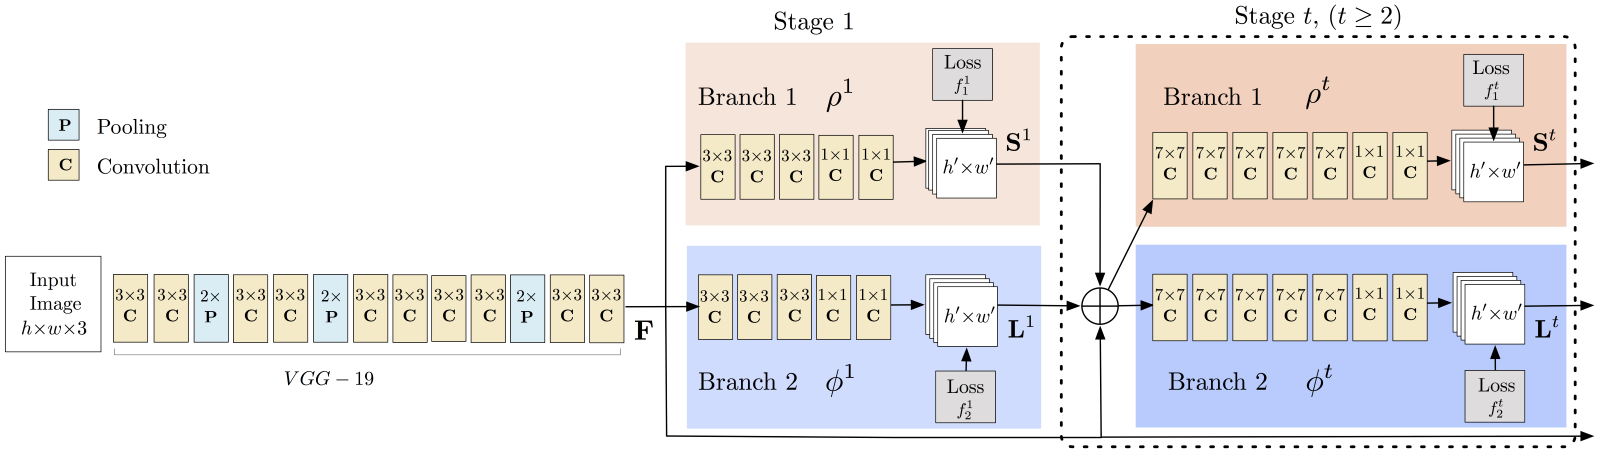

### Create keras model and load weights

In [ ]:
input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights('/content/drive/MyDrive/Kaazima/model.h5')       # orginal weights converted from caffe

### Load a sample image

In [ ]:
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util

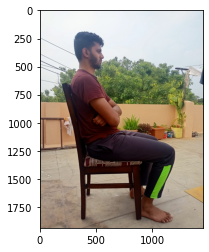

In [ ]:
test_image = 'sample_images/straight_hf_flip.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
plt.imshow(oriImg[:,:,[2,1,0]])

### Load configuration

In [ ]:
param, model_params = config_reader()
multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]

### Heatmaps and PAFs

In [ ]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

for m in range(1):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])  

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    print("Input shape: " + str(input_img.shape))  

    output_blobs = model.predict(input_img)
    print("Output shape (heatmap): " + str(output_blobs[1].shape))
    
    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
    paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)

Input shape: (1, 184, 144, 3)
Output shape (heatmap): (1, 23, 18, 19)


In [ ]:
!cat util.py

import numpy as np

def padRightDownCorner(img, stride, padValue):
    h = img.shape[0]
    w = img.shape[1]

    pad = 4 * [None]
    pad[0] = 0 # up
    pad[1] = 0 # left
    pad[2] = 0 if (h%stride==0) else stride - (h % stride) # down
    pad[3] = 0 if (w%stride==0) else stride - (w % stride) # right

    img_padded = img
    pad_up = np.tile(img_padded[0:1,:,:]*0 + padValue, (pad[0], 1, 1))
    img_padded = np.concatenate((pad_up, img_padded), axis=0)
    pad_left = np.tile(img_padded[:,0:1,:]*0 + padValue, (1, pad[1], 1))
    img_padded = np.concatenate((pad_left, img_padded), axis=1)
    pad_down = np.tile(img_padded[-2:-1,:,:]*0 + padValue, (pad[2], 1, 1))
    img_padded = np.concatenate((img_padded, pad_down), axis=0)
    pad_right = np.tile(img_padded[:,-2:-1,:]*0 + padValue, (1, pad[3], 1))
    img_padded = np.concatenate((img_padded, pad_right), axis=1)

    return img_padded, pad


### Heatmap for right knee

Right knee is 
at index 9. All body parts are defined in config: 
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

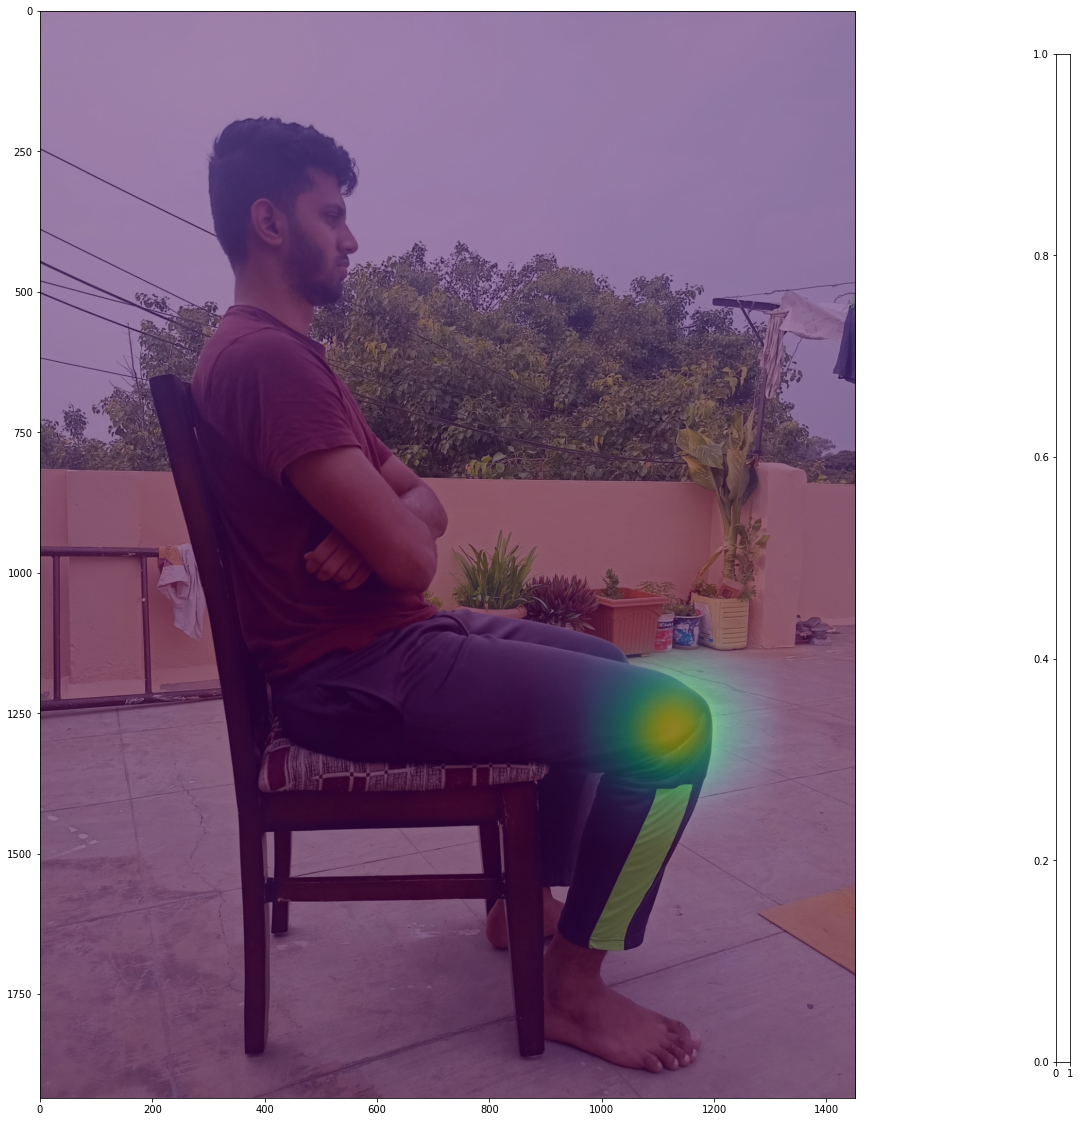

In [ ]:
plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,9], alpha=.5)
fig = matplotlib.pyplot.gcf() # Get current figure
cax = matplotlib.pyplot.gca() # Get axes of current figure
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])

### Visualise all detected body parts

In [ ]:
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

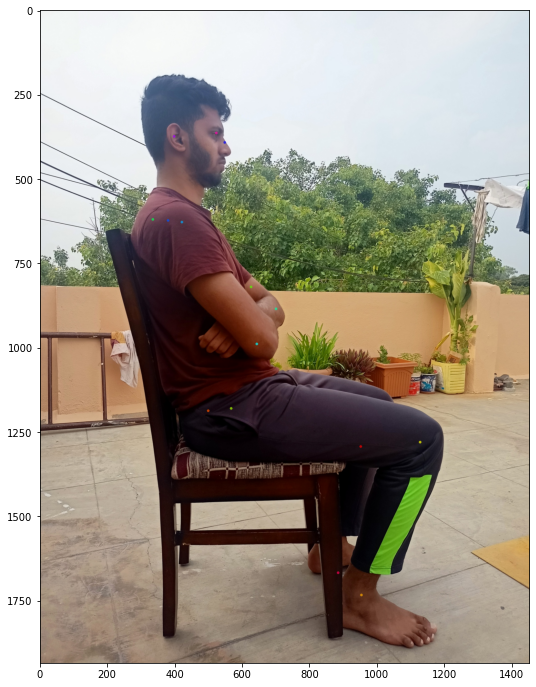

In [ ]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

calculate angle between two points with respect to x-axis (horizontal axis)

In [ ]:
#Returns angle in radians
def calcAngle(a, b):
    try:
        ax, ay = a
        bx, by = b
        if (ax == bx):
            return 1.570796
        return math.atan2(by-ay, bx-ax)
    except Exception as e:
        print("unable to calculate angle")

calculate distance between two points

In [ ]:
def calcDistance(a,b): 
	try:
		x1, y1 = a
		x2, y2 = b
		return math.hypot(x2 - x1, y2 - y1)
	except Exception as e:
		print("unable to calculate distance")

Spine position

In [ ]:
def checkPosition(all_peaks):
    try:
        f = 0
        if (all_peaks[16]): #Left ear
            a = all_peaks[16][0][0:2] #Coordinates of left ear
            f = 1
        else:
            a = all_peaks[17][0][0:2] # Coordinates of Right ear
        b = all_peaks[11][0][0:2] # Coordinates of Left hip
        angle = calcAngle(a,b)
        degrees = round(math.degrees(angle))
        if (f):
            degrees = 180 - degrees
        if (degrees<70):
            return 1
        elif (degrees > 110):
            return -1
        else:
            return 0
    except Exception as e:
        print("person not in lateral view and unable to detect ears or hip")

Function to check if hands are folding or not

In [ ]:
def checkHandFold(all_peaks):
	try:
		if (all_peaks[3][0][0:2]): #Right elbow
			try:
				if (all_peaks[4][0][0:2]): #Right wrist
					distance  = calcDistance(all_peaks[3][0][0:2],all_peaks[4][0][0:2]) #Right elbow, Right wrist
					armdist = calcDistance(all_peaks[2][0][0:2], all_peaks[3][0][0:2]) #distance between left arm-joint and left palm.
					if (distance < (armdist + 100) and distance > (armdist - 100) ): #this value 100 is arbitary. this shall be replaced with a calculation which can adjust to different sizes of people.
						print("Not Folding Hands")
					else: 
						print("Folding Hands")
			except Exception as e:
				print("Folding Hands")
	except Exception as e:
		try:
			if(all_peaks[7][0][0:2]):
				distance  = calcDistance( all_peaks[6][0][0:2] ,all_peaks[7][0][0:2])
				armdist = calcDistance(all_peaks[6][0][0:2], all_peaks[5][0][0:2])
				# print(distance)
				if (distance < (armdist + 100) and distance > (armdist - 100)):
					print("Not Folding Hands")
				else: 
					print("Folding Hands")
		except Exception as e:
			print("Unable to detect arm joints")

Function to check whether kneeling or not

In [ ]:
def checkKneeling(all_peaks):
	f = 0
	if (all_peaks[16]):
		f = 1
	try:
		if(all_peaks[10][0][0:2] and all_peaks[13][0][0:2]): # if both legs are detected
			rightankle = all_peaks[10][0][0:2]
			leftankle = all_peaks[13][0][0:2]
			hip = all_peaks[11][0][0:2]
			leftangle = calcAngle(hip,leftankle)
			leftdegrees = round(math.degrees(leftangle))
			rightangle = calcAngle(hip,rightankle)
			rightdegrees = round(math.degrees(rightangle))
		if (f == 0):
			leftdegrees = 180 - leftdegrees
			rightdegrees = 180 - rightdegrees
		if (leftdegrees > 60  and rightdegrees > 60): # 60 degrees is trail and error value here. We can tweak this accordingly and results will vary.
			print ("Both Legs are in Kneeling")
		elif (rightdegrees > 60):
			print ("Right leg is kneeling")
		elif (leftdegrees > 60):
			print ("Left leg is kneeling")
		else:
			print ("Not kneeling")

	except IndexError as e:
		try:
			if (f):
				a = all_peaks[10][0][0:2] # if only one leg (right leg) is detected
			else:
				a = all_peaks[13][0][0:2] # if only one leg (left leg) is detected
			b = all_peaks[11][0][0:2] #location of hip
			angle = calcAngle(b,a)
			degrees = round(math.degrees(angle))
			if (f == 0):
				degrees = 180 - degrees
			if (degrees > 60):
				print ("Both Legs Kneeling")
			else:
				print("Not Kneeling")
		except Exception as e:
			print("legs not detected")

In [ ]:
def showimage(img): #sometimes opencv will oversize the image when using using `cv2.imshow()`. This function solves that issue.
    screen_res = 1280, 720 #my screen resolution.
    scale_width = screen_res[0] / img.shape[1]
    scale_height = screen_res[1] / img.shape[0]
    scale = min(scale_width, scale_height)
    window_width = int(img.shape[1] * scale)
    window_height = int(img.shape[0] * scale)
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('image', window_width, window_height)
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def prinfTick(i): #Time calculation to keep a trackm of progress
    toc = time.time()
    print ('processing time%d is %.5f' % (i,toc - tic))    

In [ ]:
position = checkPosition(all_peaks) #check position of spine.
checkKneeling(all_peaks) #check whether kneeling or not
checkHandFold(all_peaks) #check whether hands are folding or not.
if (position == 1):
	  print("Hunchback")
elif (position == -1):
	  print ("Reclined")
else:
	  print("Straight")

Not kneeling
Folding Hands
Straight
